NOTE: OUTDATED, NOW IMPLEMENTED IN PROPER PY SCRIPT

In [1]:
import json
import os
import re
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import rc_context

In [2]:
sys.path.append("/home")
import src.cell_annotation_utils as cell_annotation

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [3]:
import spatialdata as sd

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
data_dir = os.path.abspath("../../data")
data_dir = os.path.abspath("/home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 53 Mar 12 17:01 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark


In [6]:
sample_name = "foxf2_s2_r1"

In [7]:
if "SLURM_CPUS_PER_TASK" in os.environ:
    sc.settings.n_jobs = int(os.environ["SLURM_CPUS_PER_TASK"])
    print(sc.settings.n_jobs)

5


# Cell type annotation

## 1. Load adata files from sdata and export for MapMyCells

In [8]:
sdata_path = os.path.join(data_dir, "samples", sample_name, "sdata_z3.zarr")
if "sdata" not in locals():
    sdata = sd.read_zarr(sdata_path)

In [9]:
sdata

SpatialData object, with associated Zarr store: /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r1/sdata_z3.zarr
├── Images
│     └── 'foxf2_s2_r1_z3': DataTree[cyx] (8, 54456, 65675), (8, 27228, 32837), (8, 13614, 16418), (8, 6807, 8209), (8, 3403, 4104)
├── Points
│     └── 'foxf2_s2_r1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── 'boundaries_Baysor_2D_CP1Merlin_075': GeoDataFrame shape: (124658, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_020': GeoDataFrame shape: (145848, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_080': GeoDataFrame shape: (133435, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_020': GeoDataFrame shape: (148669, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_080': GeoDataFrame shape: (128401, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_nucleus_100': GeoDataFrame shape: (147154, 1) (2D shapes)
│     ├── 'boundaries_Baysor_3D': GeoDataFrame shape: (149500, 1) (2D shapes)
│     ├──

In [10]:
# 50 used in squidpy tutorial, 25 used in colab script from vizgen, 20 counts or 5 genes used in Allen 2023 paper
cell_annotation.export_filter_adatas_from_sdata(
    sdata_path, sample_name, run_filter=True, min_counts=20, min_genes=5
)

Skipping adata_Baysor_2D: File already exists at /dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/data/samples/foxf2_s2_r1/sdata_z3.zarr/../results/_cell_type_annotation/adata_Baysor_2D.h5ad
Skipping adata_Baysor_3D: File already exists at /dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/data/samples/foxf2_s2_r1/sdata_z3.zarr/../results/_cell_type_annotation/adata_Baysor_3D.h5ad
Skipping adata_Cellpose_1_DAPI_PolyT: File already exists at /dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/data/samples/foxf2_s2_r1/sdata_z3.zarr/../results/_cell_type_annotation/adata_Cellpose_1_DAPI_PolyT.h5ad
Skipping adata_Cellpose_1_DAPI_Transcripts: File already exists at /dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/data/samples/foxf2_s2_r1/sdata_z3.zarr/../results/_cell_type_annotation/adata_Cellpose_1_DAPI_Transcripts.h5ad
Skipping adata_Cellpose_1_Merlin: File already exists at /dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/data/samples/foxf2_s2_r1/sdata_z3.zarr/../results/_cell_type_annotation/adata_Ce

In [11]:
# run mapmycells and upload output
# https://knowledge.brain-map.org/mapmycells/process/

## 2. Load and QC MapMyCells Output

In [12]:
allen_mmc_dir = os.path.join(sdata_path, "..", "results", "_cell_type_annotation")
mmc_out = [
    f
    for f in os.listdir(allen_mmc_dir)
    if "_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping" in f
]
mmc_out

['adata_Ficture_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742133247747',
 'adata_Negative_Control_Voronoi_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742133206334',
 'adata_Cellpose_1_DAPI_Transcripts_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742132934677',
 'adata_Baysor_2D_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742130567950',
 'adata_Cellpose_2_DAPI_Transcripts_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742133284170',
 'adata_Negative_Control_Rastered_10_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742131838338',
 'adata_Negative_Control_Rastered_20_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742131845479',
 'adata_Cellpose_1_Merlin_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742132454097',
 'adata_Cellpose_1_DAPI_PolyT_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1742131921025',
 'adata_Baysor_3D_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_174213140

In [13]:
# unpack and delete zip mmc output
for file in mmc_out:
    if file.endswith(".zip"):
        file_path = os.path.join(allen_mmc_dir, file)
        unzip_path = os.path.join(allen_mmc_dir, file.replace(".zip", ""))
        !unzip "{file_path}" -d "{unzip_path}"
        !rm "{file_path}"

In [15]:
mmc_file = mmc_out[7]
json_name = os.path.splitext(mmc_file)[0]

# Find subfolder name from json_name using regex
subfolder = re.search(r"_(.+?)_10xWholeMouseBrain", json_name).group(1)
subfolder

'Cellpose_1_Merlin'

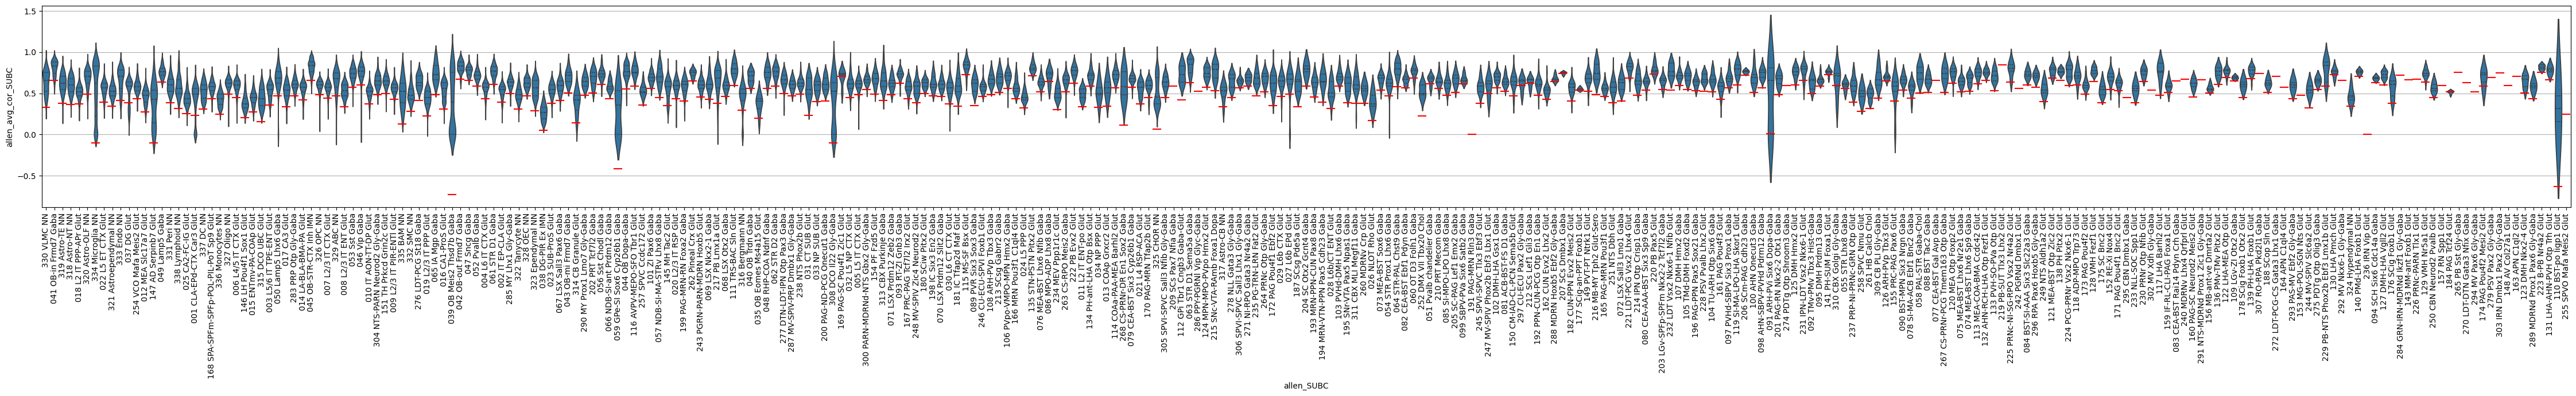

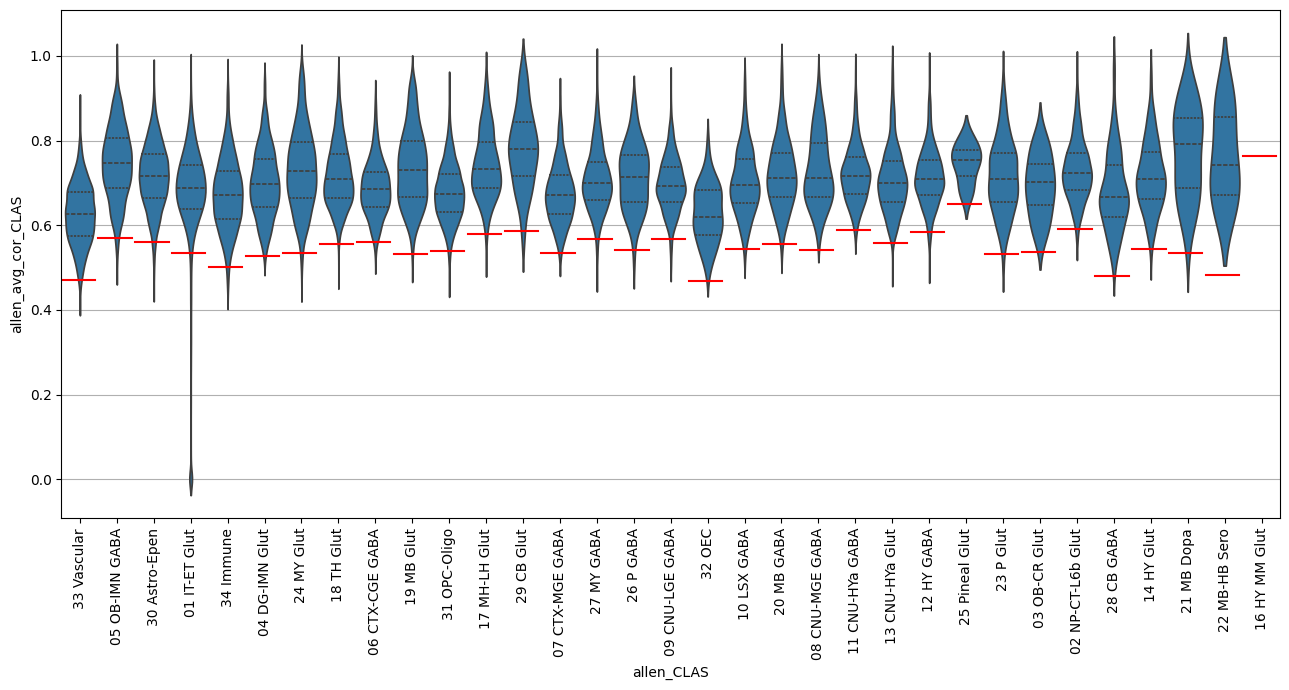

In [16]:
# Load MapMyCells JSON and QC (mark low-quality mappings as "Undefined")
mad_factor = 3

# Load and process data
json_path = os.path.join(allen_mmc_dir, json_name, json_name, f"{json_name}.json")
with open(json_path, "rb") as src:
    json_results = json.load(src)
mapping_result = {c["cell_id"]: c for c in json_results["results"]}
allen_mmc_metadata = cell_annotation.process_allen_metadata(
    json_results, mapping_result
)

# Create output directory
output_dir = os.path.join(
    sdata_path, "..", "results", subfolder, "cell_type_annotation"
)
os.makedirs(output_dir, exist_ok=True)

# Plot MAD thresholds for SUBC and CLAS (per cell type)
for allen_key, figsize in [("SUBC", (45, 7)), ("CLAS", (13, 7))]:
    cell_annotation.plot_mad_thresholds(
        allen_mmc_metadata,
        out_path=output_dir,
        name=f"{allen_key}_mad_threshold",
        group_column=f"allen_{allen_key}",
        value_column=f"allen_avg_cor_{allen_key}",
        mad_factor=mad_factor,
        figsize=figsize,
    )
    plt.show()

# QC: Flag low-quality mappings
taxonomy_levels = ["CLAS", "SUBC", "SUPT", "CLUS"]
for level in taxonomy_levels:
    cell_annotation.flag_low_quality_mappings(
        df=allen_mmc_metadata,
        group_col=f"allen_{level}",
        value_col=f"allen_avg_cor_{level}",
        mad_factor=mad_factor,
        inplace=True,
    )

## 3. Load empty adata and add MapMyCells labels

In [34]:
adata = sdata["adata_" + subfolder].copy()
adata.shape

(107013, 500)

In [36]:
adata.obs = adata.obs.merge(
    allen_mmc_metadata, left_index=True, right_index=True, how="left"
)

# filter cells; required for cell matching with mmc output
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.filter_cells(adata, min_genes=5)
assert not all(adata.obs.head().isna().any())

In [37]:
# Set raw counts
if "counts" not in adata.layers:
    adata.layers["counts"] = adata.X.copy()
adata.X = adata.layers["counts"].copy()

In [42]:
if "area" in adata.obs.columns:
    cell_annotation.normalize_counts(
        adata, method="area"
    )  # Area normalization (default)
elif "volume" in adata.obs.columns:
    cell_annotation.normalize_counts(adata, method="volume")  # Volume normalization
cell_annotation.normalize_counts(adata, method="library");  # Library size normalization

AnnData object with n_obs × n_vars = 75924 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'App_raw', 'App_high_pass', 'Aldoc_raw', 'Aldoc_high_pass', 'Sst_raw', 'Sst_high_pass', 'Plp1_raw', 'Plp1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'allen_avg_cor_CLAS', 'allen_CLAS', 'allen_avg_cor_SUBC', 'allen_SUBC', 'allen_avg_cor_SUPT', 'allen_SUPT', 'allen_avg_cor_CLUS', 'allen_CLUS', 'n_counts', 'n_genes'
    uns: 'spatialdata_attrs'
    obsm: 'blank', 'spatial'
    layers: 'counts', 'volume_norm', 'volume_log1p_norm', 'zscore', 'library_norm', 'library_log1p_norm'

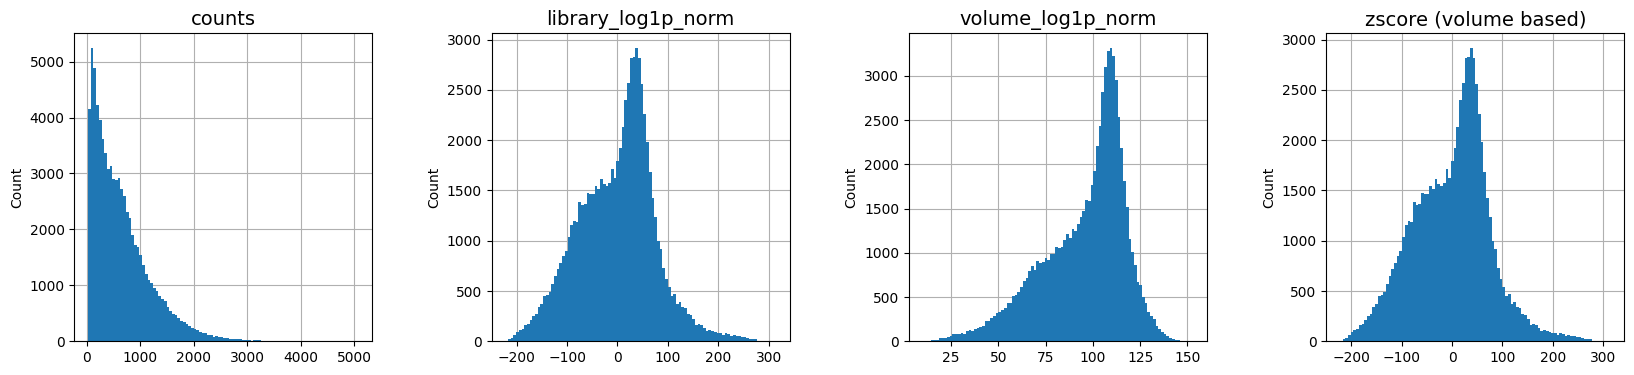

In [58]:
# Find area log-normalized layer
area_log_key = next(
    (
        k
        for k in adata.layers.keys()
        if k.endswith("_log1p_norm") and k != "library_log1p_norm"
    ),
    None,
)

# Plot distributions
fig, axs = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"wspace": 0.4})

titles = ["counts", "library_log1p_norm", f"{area_log_key}", "zscore (volume based)"]
data_arrays = [
    adata.layers["counts"].sum(1),
    adata.layers["library_log1p_norm"].sum(1),
    adata.layers[area_log_key].sum(1),
    adata.layers["zscore"].sum(1),
]

for ax, data, title in zip(axs, data_arrays, titles):
    sns.histplot(data, kde=False, bins=100, ax=ax, zorder=2, alpha=1)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    if ax.get_legend():
        ax.get_legend().remove()
    for patch in ax.patches:
        patch.set_edgecolor("none")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "compare_normalizations.png"), dpi=200)
plt.show()

In [59]:
adata.X = adata.layers["zscore"]
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [60]:
# quality metrics
with rc_context({"figure.figsize": (9, 8)}):
    sc.pl.umap(
        adata,
        color=[
            "allen_avg_cor_CLAS",
            "allen_avg_cor_SUBC",
            "allen_avg_cor_SUPT",
            "allen_avg_cor_CLUS",
        ],
        size=4,
        legend_fontoutline=2,
        legend_fontsize=10,
        ncols=4,
        show=False,
    )
    plt.tight_layout()
    plt.gca().set_aspect(1)
    plt.savefig(
        os.path.join(output_dir, "UMAP_mapmycells_quality_metrics.png"), dpi=200
    )
    plt.show()

In [61]:
# format and collapse cell types from MapMyCells
adata.obs = cell_annotation.group_cell_types(adata.obs)

cell_type_order = [
    "ECs",
    "Pericytes",
    "SMCs",
    "VLMCs",
    "Ependymal",
    "Choroid Plexus",
    "Astrocytes",
    "Oligodendrocytes",
    "OPCs",
    "Microglia",
    "BAMs",
    "Immune-Other",
    "Neurons-Gaba",
    "Neurons-Glut",
    "Neurons-Dopa",
    "Neurons-Immature",
    "Neurons-Other",
    "OECs",
    "Undefined",
]
adata.obs["cell_type"] = pd.Categorical(
    adata.obs["cell_type"], categories=cell_type_order
)

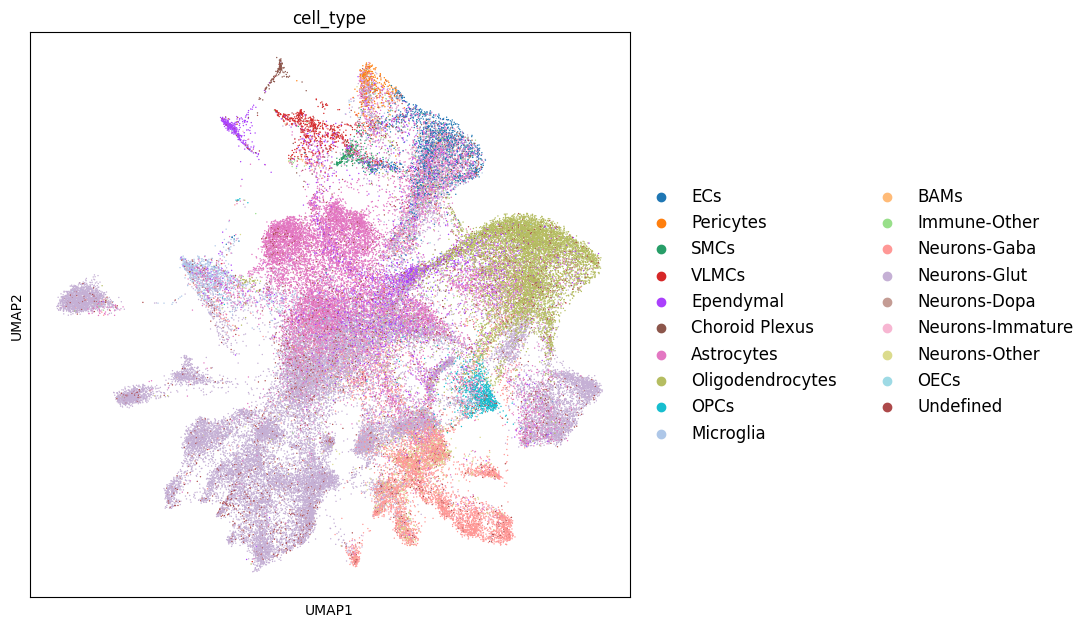

In [62]:
# plot cell type labels
with rc_context({"figure.figsize": (11, 8)}):
    sc.pl.umap(
        adata,
        color=["cell_type"],
        size=4,
        legend_fontoutline=2,
        legend_fontweight="normal",
        legend_fontsize=12,
        return_fig=True,
    )
    plt.tight_layout()
    plt.gca().set_aspect(1)
    plt.savefig(
        os.path.join(output_dir, "UMAP_mapmycells_cell_types.png"),
        dpi=200,
        bbox_inches="tight",
    )
    plt.show()

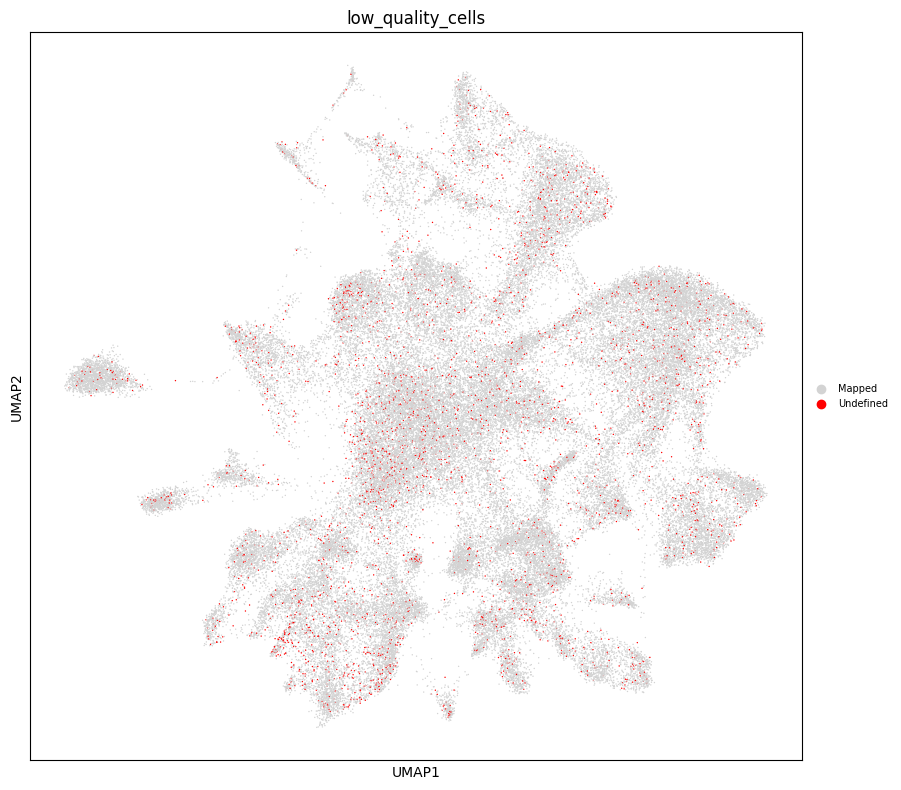

In [63]:
# highlight low-quality cells
adata.obs["low_quality_cells"] = adata.obs["cell_type"].apply(
    lambda x: "Undefined" if x == "Undefined" else "Mapped"
)
with rc_context({"figure.figsize": (11, 8)}):
    sc.pl.umap(
        adata,
        color="low_quality_cells",
        size=4,
        legend_fontoutline=2,
        legend_fontweight="normal",
        legend_fontsize=7,
        palette={"Undefined": "red", "Mapped": "lightgrey"},
        return_fig=True,
    )
    plt.tight_layout()
    plt.gca().set_aspect(1)
    plt.savefig(
        os.path.join(output_dir, "UMAP_mapmycells_low_quality_cells.png"),
        dpi=200,
        bbox_inches="tight",
    )
    plt.show()
del adata.obs["low_quality_cells"]

## 4. Improve labels using clustering and scores

Rationale: Using well-working but noisy tool MapMyCells, in combination with classical approaches: Leiden clustering to reduce noise and cell type marker scoring to verify label. 

Summary
1. Cell-level annotations based on automated reference mapping using MapMyCells (Yao 2023 Nature) 
> - After filtering low-quality cells
> - Mapping outcome is qc-ed by turning low-quality labels to "Undefined"
2. Cluster-based Assignment: To de-noise cell-level annotation, high-resolution Leiden clusters are assigned the most prevalent cell label.
> - Cell types with fewer than min_cells (default 100) total mapped cells are removed.  
> - Cell counts are normalized by the total number of cells of that type, hence values represent the percentage of each cell type's total population is found in each cluster. This ensures that cell types with naturally higher abundance don't automatically dominate all clusters.  
> - Run Leiden clustering with high resolution to obtain small clusters (default 3.0).
> - For each cluster, select and assign with the cell type with highest normalized cell percentage in that cluster.
3. Marker Gene Scoring
> - sc.tl.score() of Yao 2023 Nature marker genes, Scores each cell for expression of cell type marker genes, 
4. Final Cell Type Assignment
> - For each cluster: Collects scores for all cell types, Identifies highest-scoring cell type, If highest score > threshold (0.25), assigns that cell type, If reassigning from initial type (step 2) logs the change, If no score above threshold, marks as "Undefined".
5. Output
> - Reports clusters marked as "Undefined" with reasons
> - Provides summary statistics of assigned cells
> - Returns a summary dataframe with initial and final assignments

In [64]:
# load marker genes
# from Allen mouse brain scRNA-seq atlas (Yao 2023 Nature, 4M cells)
# computed using edgeR of pseudobulks, using author-derived cell annotations (see separate script)
ABCAtlas_marker_df = pd.read_csv(
    os.path.join(
        data_dir,
        "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "marker_genes",
        "20250211_cell_type_markers_top50.csv",
    )
)
# turn ABCAtlas_marker_df to dict
cell_types = ABCAtlas_marker_df.columns.tolist()
cell_type_dict = {}
for cell_type in cell_types:
    # Skip the index column (0) if present
    if cell_type == "0":
        continue
    # Get values from column, excluding the header row
    genes = ABCAtlas_marker_df[cell_type].iloc[0:].tolist()
    # Remove any NaN values
    genes = [gene for gene in genes if pd.notna(gene)]
    cell_type_dict[cell_type] = genes

In [65]:
leiden_res = 3.0
adata, summary_df, normalized_crosstab, cluster_score_matrix = (
    cell_annotation.cell_type_annotation_pipeline(
        adata,
        marker_genes_dict=cell_type_dict,
        leiden_res=leiden_res,
        score_threshold=0.5,
        top_n_genes=25,
    )
)

Running leiden clustering with resolution 3.0...
1. Assigning cell types based on cluster composition...
2. Scoring cells for marker gene expression...
       'Bank1', 'C1qb', 'Spi1', 'Tyrobp', 'C3ar1', 'Mir142hg', 'Cd84'],
      dtype='object')
       'Ak7', 'Rarres2', 'Ankub1', 'Cfap299', 'Ttll8', 'Tm4sf1', 'Spag6l',
       'Spef2', 'Dnah9', 'Vwa3a', 'Dnah5', 'Slc13a4', 'Gm973', 'Otx2os1'],
      dtype='object')
       'Mrvi1', 'Tbx3os1', 'Crip1', 'Cavin1', 'Ano1', 'Mylk', 'Adap2', 'Mcam',
       'Lamc3'],
      dtype='object')
       'Adap2', 'Morrbid', 'Ano1', 'Slc22a8', 'Adap2os', 'Myl9', 'Sod3',
       'Slc16a12', 'Tm4sf1'],
      dtype='object')
       'Selplg', 'Cd86', 'Fcrls', 'Csf3r', 'Cd300c2', 'Gpr34', 'Il10ra',
       'Inpp5d', 'Spi1', 'Mpeg1'],
      dtype='object')
       'Slc6a20a', 'Prelp', 'Itih5', 'Ogn'],
      dtype='object')
       'Slc22a8', 'Hmcn1', 'Prom1', 'Slfn5', 'Cd34'],
      dtype='object')
       'Selplg', 'Inpp5d', 'Arhgap15', 'Csf3r', 'Fcer1g', 'Runx1',

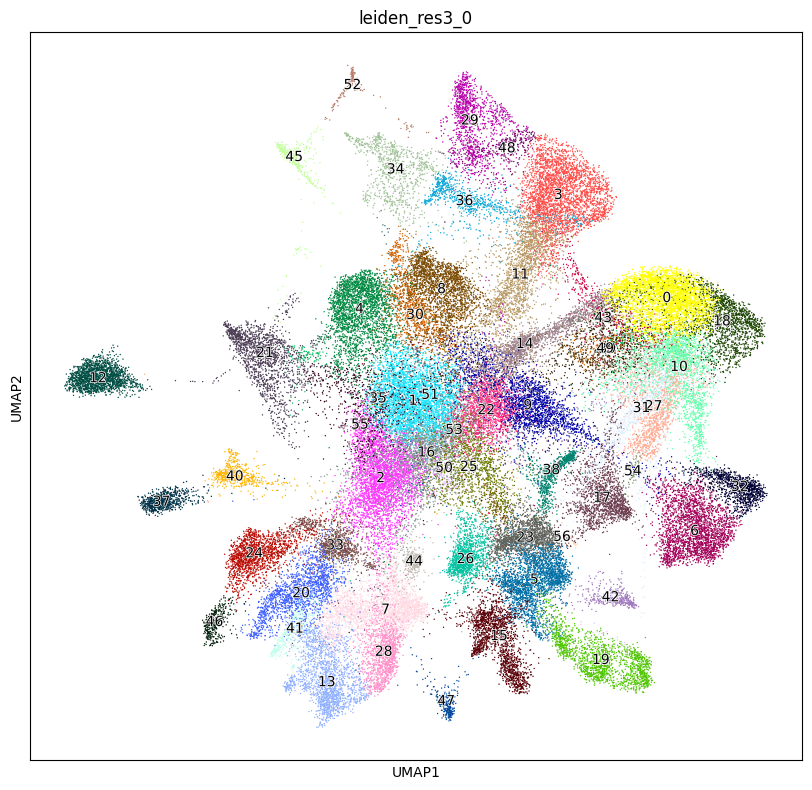

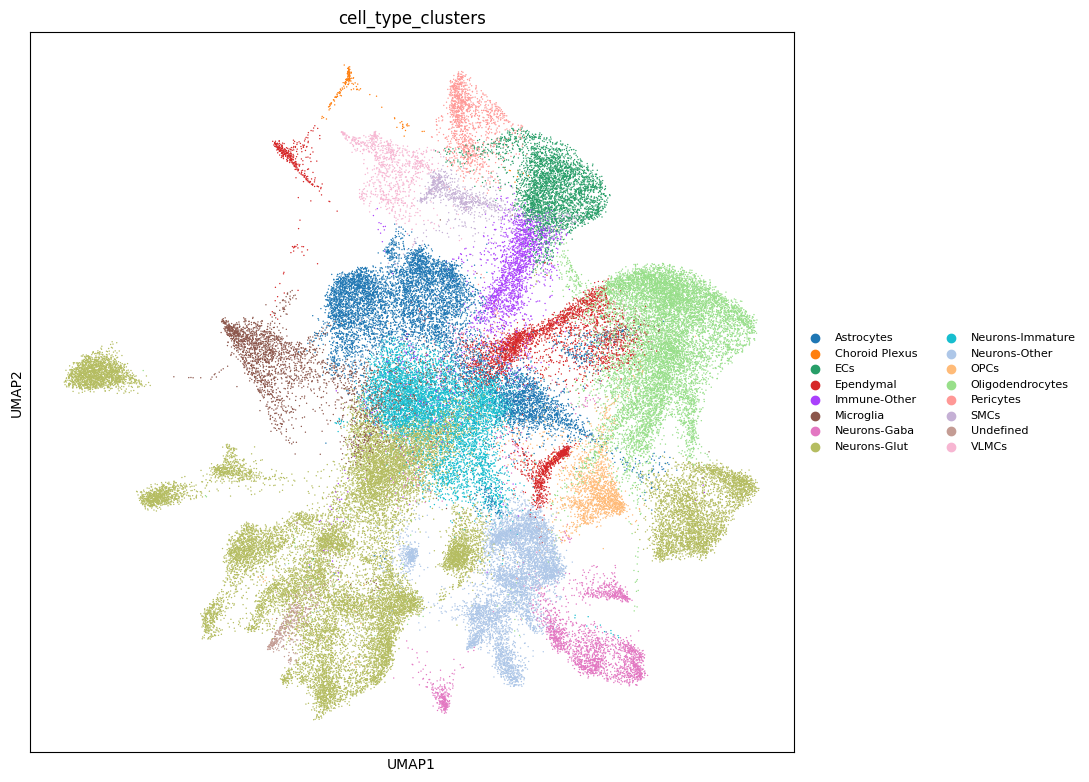

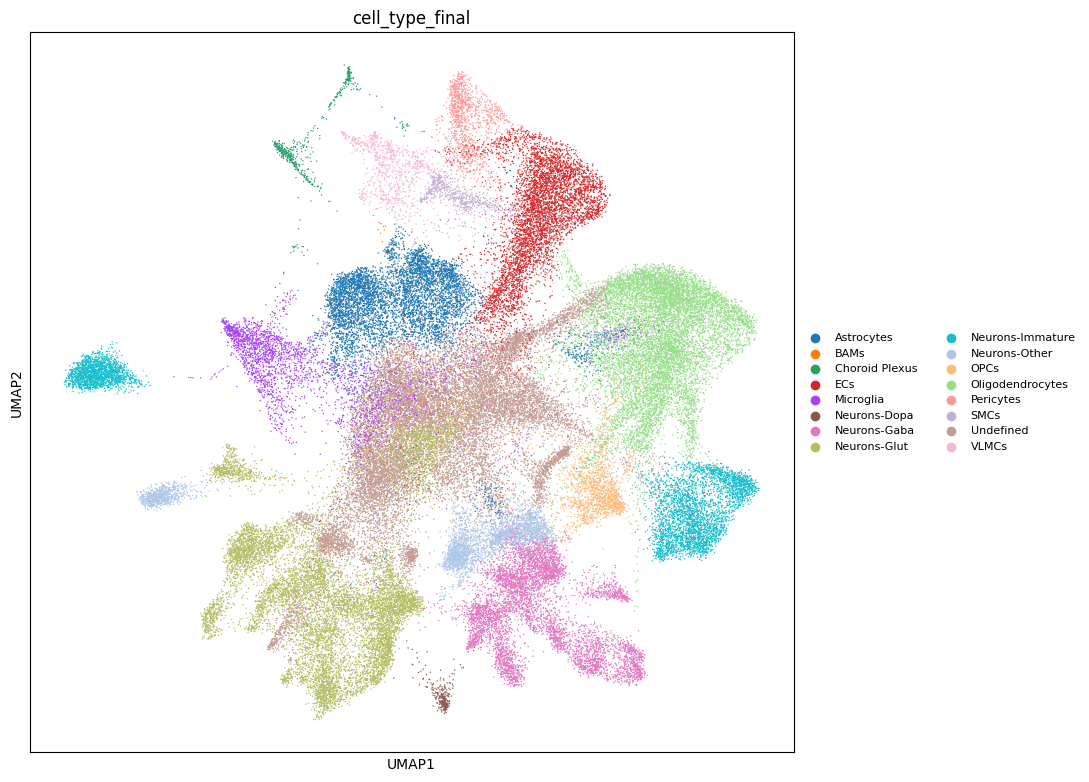

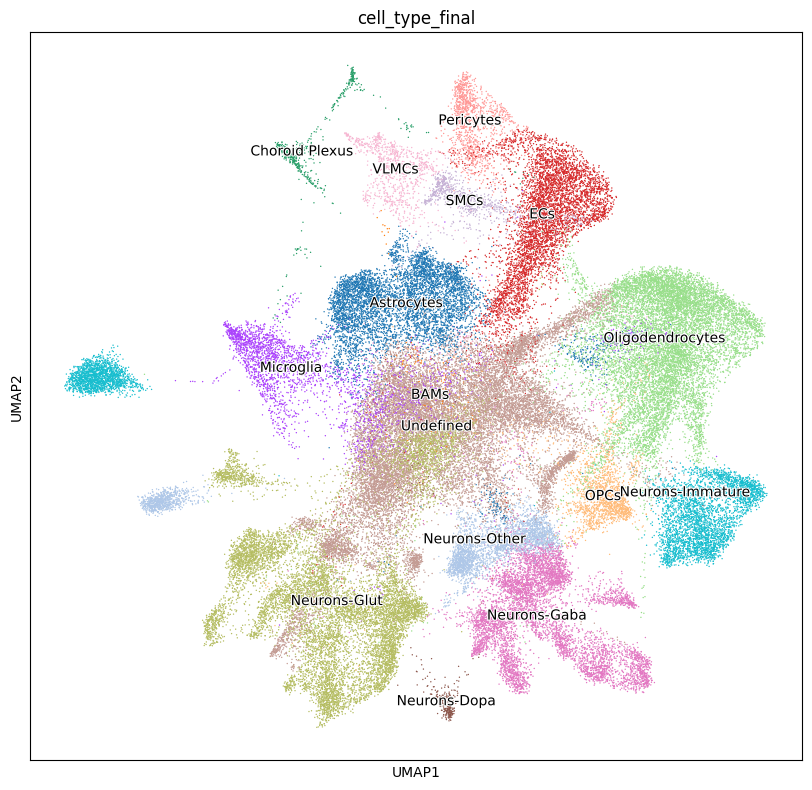

In [66]:
def plot_umap(
    adata,
    color_by,
    legend_loc=None,
    legend_fontsize=8,
    legend_fontoutline=1,
    figsize=(11, 8),
    output_filename=None,
):
    with rc_context({"figure.figsize": figsize}):
        fig = sc.pl.umap(
            adata,
            color=color_by,
            size=4,
            legend_loc=legend_loc,
            legend_fontoutline=legend_fontoutline,
            legend_fontweight="normal",
            legend_fontsize=legend_fontsize,
            return_fig=True,
        )
        plt.tight_layout()
        plt.gca().set_aspect(1)

        if output_filename:
            plt.savefig(
                os.path.join(output_dir, output_filename), dpi=200, bbox_inches="tight"
            )

        return fig


# Generate plots with different coloring parameters
plot_umap(
    adata,
    f"leiden_res{leiden_res}".replace(".", "_"),
    legend_loc="on data",
    legend_fontsize=10,
    output_filename=f"UMAP_leiden_res{leiden_res}.png",
)

plot_umap(
    adata,
    "cell_type_clusters",
    legend_loc="right margin",
    output_filename="UMAP_mapmycells_cell_types_denoised.png",
)  # step 1 / majority vote

plot_umap(
    adata,
    "cell_type_final",
    legend_loc="right margin",
    output_filename="UMAP_cell_types_final.png",
)  # step 3 / incl score refinement

plot_umap(
    adata,
    "cell_type_final",
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=1.5,
    figsize=(9, 8),
    output_filename="UMAP_cell_types_final_legendondata.png",
)
plt.show()

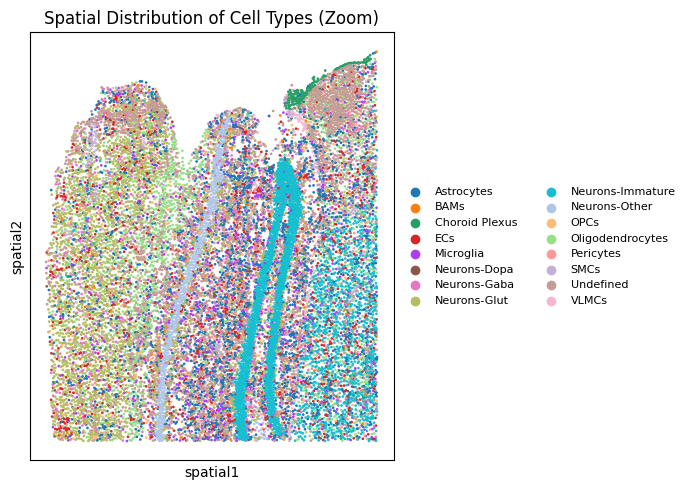

In [79]:
xmin_full = adata.obsm["spatial"][:, 0].min()
xmax_full = adata.obsm["spatial"][:, 0].max()
ymin_full = adata.obsm["spatial"][:, 1].min()
ymax_full = adata.obsm["spatial"][:, 1].max()
x_min, x_max = xmin_full, xmax_full - (xmax_full - xmin_full) / 1.75
y_min, y_max = ymin_full + (ymax_full - ymin_full) / 1.75, ymax_full
mask = (
    (adata.obsm["spatial"][:, 0] >= x_min)
    & (adata.obsm["spatial"][:, 0] <= x_max)
    & (adata.obsm["spatial"][:, 1] >= y_min)
    & (adata.obsm["spatial"][:, 1] <= y_max)
)
adata_subset = adata[mask]
with rc_context({"figure.figsize": (7, 5)}):
    sc.pl.embedding(
        adata_subset,
        basis="spatial",
        color="cell_type_final",
        size=15,
        alpha=1,
        legend_fontsize=8,
        title="Spatial Distribution of Cell Types (Zoom)",
        show=False,
    )
    plt.tight_layout()
    plt.savefig(
        os.path.join(output_dir, "Spatial_topleft_corner_cell_types_final.png"),
        dpi=200,
        bbox_inches="tight",
    )
    plt.show()

# Export cell type labels

In [31]:
if "area_norm" in adata.layers:
    del adata.layers["area_norm"]  # compatibility
adata.write_h5ad(
    os.path.join(output_dir, "adata_annotated.h5ad.gz"), compression="gzip"
)

In [32]:
normalized_crosstab.to_csv(
    os.path.join(output_dir, "mapmycells_leiden_crosstab_normalized_.csv")
)
cluster_score_matrix.to_csv(os.path.join(output_dir, "markerscore_leiden_matrix.csv"))